# 1. Introduction

## 1.1 Challenge Overview
Fine-tune a pretrained ResNet-50 model on the Oxford Flowers-102 dataset

## 1.2 Motivation
I chose this challenge to extend my YOLOv8 internship experience into transfer learning on image data and showcase my deep-learning skills.

# 📑 Table of Contents

0. [Setup & Dependencies](#0-setup--dependencies)  
1. [Introduction](#1-introduction)  
   1.1 [Challenge Overview](#11-challenge-overview)  
   1.2 [Motivation](#12-motivation)  
2. [Dataset Preparation](#2-dataset-preparation)  
   2.1 [Download & Extraction](#21-download--extraction)  
   2.2 [Folder Organization](#22-folder-organization)  
3. [Data Pipeline](#3-data-pipeline)  
4. [Model Setup](#4-model-setup)  
5. [Training & Validation](#5-training--validation)  
6. [Results & Analysis](#6-results--analysis)  
7. [Conclusion & Next Steps](#7-conclusion--next-steps)  

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/drive/1aRfGqxm3T_7cx4ZumUlXi2e-PxToS49S)

# 0. Setup & Dependencies

In [1]:
import os
import urllib.request
import zipfile
import scipy.io as sio
from pathlib import Path
from shutil import move

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [3]:
import random # import the random module
seed = 42
random.seed(seed)
import numpy as np # import the numpy module
np.random.seed(seed)
import torch # import the torch module
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# 2. Dataset Preparation

In [4]:
import urllib.request
import tarfile

## 2.1 Download & Extraction

In [5]:
# fetching and saving

urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz',
    '102flowers.tgz')

# extracting into .jpg

with tarfile.open('102flowers.tgz', 'r:gz') as archive:
  archive.extractall()

In [6]:
# grabbing the .mat files

urllib.request.urlretrieve(
    'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
    'imagelabels.mat'
)

urllib.request.urlretrieve(
    'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat',
    'setid.mat'
)

('setid.mat', <http.client.HTTPMessage at 0x7f3c1ec72390>)

## 2.2 Folder Organization

In [7]:
# sorting images into train, val, test

import scipy.io as sio
import os
from shutil import move

# reading in labels and splitting the indices

labels = sio.loadmat('imagelabels.mat')['labels'][0]
splits = sio.loadmat('setid.mat')
train_ids = set(splits['trnid'][0])
val_ids = set(splits['valid'][0])
test_ids = set(splits['tstid'][0])

In [8]:
# creating folders for each split/class

for split in ('train', 'val', 'test'):
  for cls_idx in range(1, 103):
    os.makedirs(f'{split}/{cls_idx:03d}', exist_ok=True)

In [9]:
import pandas as pd

counts = {
    'Split': ['Train', 'Val', 'Test'],
    'Images': [len(train_ids), len(val_ids), len(test_ids)]
}
pd.DataFrame(counts)

,Split,Images
0,Train,1020
1,Val,1020
2,Test,6149


In [10]:
# moving each image
for idx, cls in enumerate(labels, 1):
  if idx in train_ids:
    subset = 'train'
  elif idx in val_ids:
    subset = 'val'
  else:
    subset = 'test'
  src = f'jpg/image_{idx:05d}.jpg'
  dst = f'{subset}/{cls:03d}/image_{idx:05d}.jpg'
  move(src, dst)

# 3. Data Pipeline

In [11]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

Image Transformation

In [12]:
# mean/std from ImageNet

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms: resize -> random flip -> to tensor -> normalize

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # match ResNet input size
    transforms.RandomHorizontalFlip(),       # simple augmentation
    transforms.ToTensor(),                   # H*W*C -> C*H*W, [0->255] -> [0-1]
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation/Test transforms: resize -> to tensor -> normalize

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [13]:
# Creating Datasets

train_dataset = ImageFolder(root='train', transform=train_transform)
val_dataset = ImageFolder(root='val', transform=val_transform)
test_dataset = ImageFolder('test', transform=val_transform)

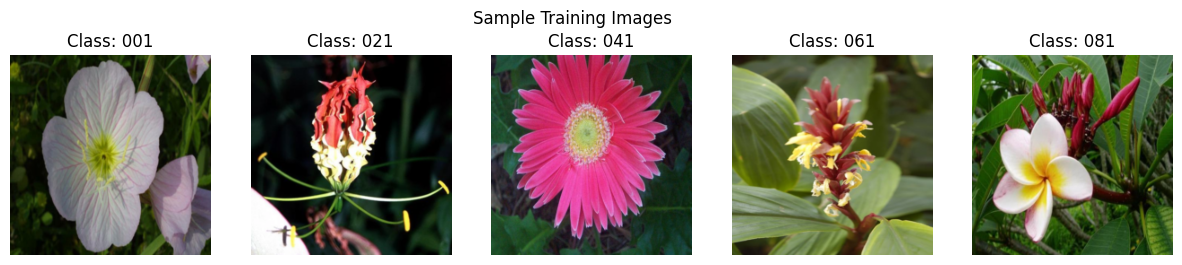

In [15]:
# Display 5 random training images
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset[i*200]  # pick spaced examples
    # Convert IMAGENET_STD and IMAGENET_MEAN to tensors before operations
    ax.imshow(img.permute(1,2,0) * torch.tensor(IMAGENET_STD) + torch.tensor(IMAGENET_MEAN))
    ax.set_title(f"Class: {train_dataset.classes[label]}")
    ax.axis('off')
plt.suptitle("Sample Training Images")
plt.show()

In [16]:
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Training images: 1020
Validation images: 1020
Test images: 6149


Building DataLoaders

In [17]:
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# 4. Model Setup

Importing & Device Setup

In [18]:
import torch
from torchvision import models
from torch import nn

# picking GPU if it's there, otherwise CPU

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on:", device)

Running on: cuda


Loading the Pretrained Model

In [19]:
# Grabbing the NesNet-50 pretrained on ImageNet

resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Freezing Early Layers

In [20]:
for param in resnet50.parameters():
  param.requires_grad = False

In [21]:
# Confirm only fc is trainable
for name, param in resnet50.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name} → {tuple(param.shape)}")

Replacing the Final Fully-Connected Layer

In [22]:
# resnet50.fc is a nn.Linear mapping from 2048 features to 1000 classes.
# Swapping it out so it outputs 102 classes instead.

num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 102)

Sending Model to Device

In [23]:
resnet50 = resnet50.to(device)

## Define Loss & Optimizer

Loss Function

In [24]:
# For multi-class classification, CrossEntropyLoss is standard

criterion = nn.CrossEntropyLoss()

Optimizer

In [25]:
import torch.optim as optim

# Using Adam to train just the final layer's weights

optimizer = optim.Adam(
    resnet50.fc.parameters(),
    lr = 1e-3
)

# 5. Training & Validation

### Training and Evaluation Loop

In [26]:
import time
import torch

def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0
  correct = 0
  total = 0

  for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    preds = outputs.argmax(dim=1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  avg_loss = running_loss / total
  accuracy = correct / total
  return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * images.size(0)
      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# ------Run Training--------

num_epochs = 5
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, num_epochs +1):
  start_time = time.time()

  train_loss, train_acc = train_one_epoch(
      resnet50, train_loader, optimizer, criterion, device
  )
  val_loss, val_acc = evaluate(
      resnet50, val_loader, criterion, device
  )

  elapsed = time.time() - start_time
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  print(
      f"Epoch {epoch}/{num_epochs} | "
      f"Train - loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
      f"Val - loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
      f"{elapsed:.1f}s"
  )

Epoch 1/5 | Train - loss: 4.5828, acc: 0.0922 | Val - loss: 3.3845, acc: 0.3441 | 13.5s
Epoch 2/5 | Train - loss: 2.6515, acc: 0.5382 | Val - loss: 2.3435, acc: 0.5824 | 13.5s
Epoch 3/5 | Train - loss: 1.5833, acc: 0.8137 | Val - loss: 1.6788, acc: 0.7147 | 12.8s
Epoch 4/5 | Train - loss: 1.0034, acc: 0.9088 | Val - loss: 1.3189, acc: 0.7912 | 11.8s
Epoch 5/5 | Train - loss: 0.6839, acc: 0.9539 | Val - loss: 1.1169, acc: 0.8186 | 13.1s


In [27]:
import pandas as pd

df = pd.DataFrame({
    'Epoch': range(1, num_epochs+1),
    'Train Loss': history['train_loss'],
    'Train Acc': history['train_acc'],
    'Val Loss': history['val_loss'],
    'Val Acc': history['val_acc']
})
df.style.format({
    'Train Loss': '{:.4f}', 'Val Loss': '{:.4f}',
    'Train Acc': '{:.3f}',  'Val Acc': '{:.3f}'
})

,Epoch,Train Loss,Train Acc,Val Loss,Val Acc
0,1,4.5828,0.092,3.3845,0.344
1,2,2.6515,0.538,2.3435,0.582
2,3,1.5833,0.814,1.6788,0.715
3,4,1.0034,0.909,1.3189,0.791
4,5,0.6839,0.954,1.1169,0.819


# 6. Results & Analysis

Plotting Loss Curves

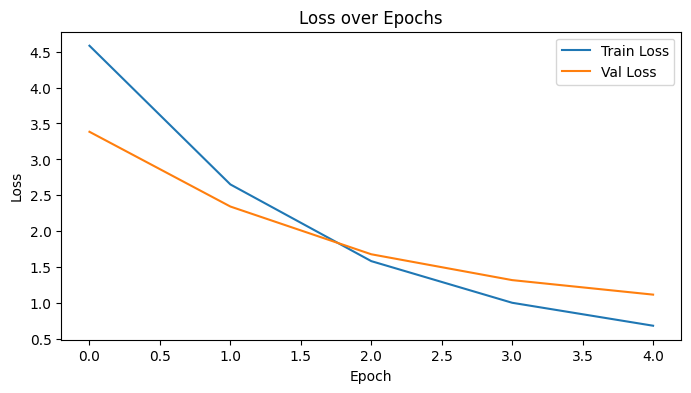

In [28]:
import matplotlib.pyplot as plt

# Loss Curves

plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label = 'Train Loss')
plt.plot(history['val_loss'], label = 'Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting Accuracy Curves

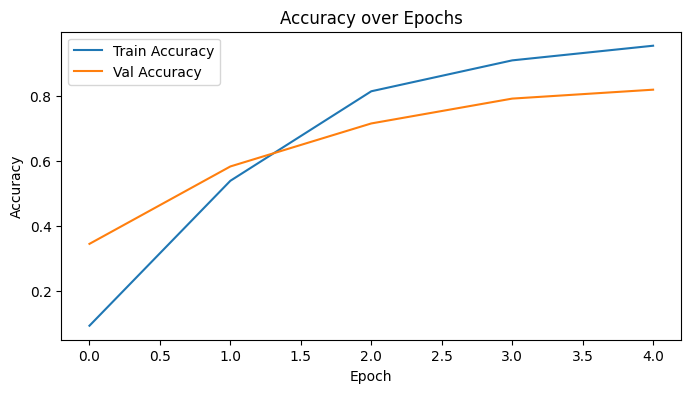

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(history['train_acc'], label = 'Train Accuracy')
plt.plot(history['val_acc'], label = 'Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluating on the Test Set

In [30]:
test_loss, test_acc = evaluate(resnet50, test_loader, criterion, device)
print(f"Test  - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test  - loss: 1.2525, acc: 0.7720


## Confusion Matrix & Classification Report

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import torch


resnet50.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = resnet50(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(
    all_labels, all_preds,
    target_names=test_dataset.classes,  # list of '001', '002', … class names
    digits=3
))

cm = confusion_matrix(all_labels, all_preds)


              precision    recall  f1-score   support

         001      0.314     0.800     0.451        20
         002      0.947     0.900     0.923        40
         003      0.294     0.250     0.270        20
         004      0.727     0.222     0.340        36
         005      0.818     0.800     0.809        45
         006      0.781     1.000     0.877        25
         007      0.531     0.850     0.654        20
         008      0.793     1.000     0.884        65
         009      0.875     0.808     0.840        26
         010      0.758     1.000     0.862        25
         011      0.556     0.672     0.608        67
         012      0.955     0.955     0.955        67
         013      0.879     1.000     0.935        29
         014      0.900     0.964     0.931        28
         015      0.686     0.828     0.750        29
         016      0.625     0.476     0.541        21
         017      0.968     0.923     0.945        65
         018      0.721    

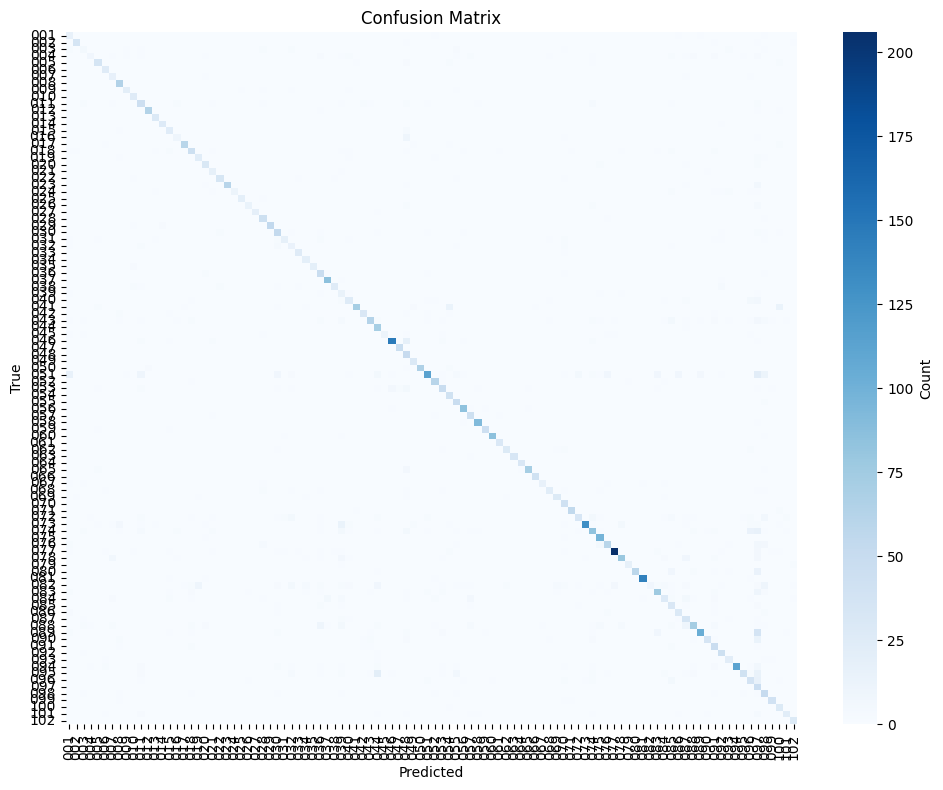

In [34]:
import seaborn as sns # Import the seaborn library

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", fmt='d',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cbar_kws={'label':'Count'})
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Error Analysis: Most Confused Class Pairs

Most confused: True class 88 (089) → Predicted 96 (097) with 37 instances


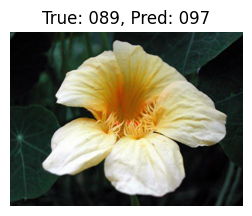

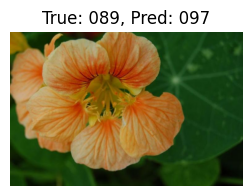

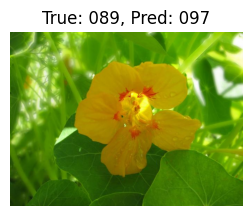

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Ignoring the diagonal so we only look at off-diagonal confusions:
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# 2) Finding the indices (true, pred) of the largest confusion:
true_idx, pred_idx = np.unravel_index(cm_no_diag.argmax(), cm_no_diag.shape)
print(f"Most confused: True class {true_idx} ({test_dataset.classes[true_idx]}) → "
      f"Predicted {pred_idx} ({test_dataset.classes[pred_idx]}) "
      f"with {cm_no_diag[true_idx,pred_idx]} instances")

# 3) Collecting up to 3 misclassified examples for that pair:
mis = [(i,p,t)
       for i,(p,t) in enumerate(zip(all_preds, all_labels))
       if (t==true_idx and p==pred_idx)][:3]

# 4) Plotting them:
for idx, pred, true in mis:
    img_path = test_dataset.imgs[idx][0]
    img = plt.imread(img_path)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f"True: {test_dataset.classes[true]}, Pred: {test_dataset.classes[pred]}")
    plt.axis('off')
    plt.show()

# 7. Conclusion & Next Steps

In [36]:
torch.save(resnet50.state_dict(), 'resnet50_flowers102.pth')


In [37]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 102)
model.load_state_dict(torch.load('resnet50_flowers102.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>